# Offline Evaluation: Compare Agent Actions vs Expert Actions

This notebook:
1. Loads a checkpoint from training
2. Loads the first 500 samples from merged_data_states.npz
3. Passes observations through the agent to get predicted actions
4. Denormalizes the predicted actions
5. Compares with expert actions (also denormalized)
6. Shows statistics on the differences

In [1]:
import os
import sys
import numpy as np
import pickle
import jax
import matplotlib.pyplot as plt
from pathlib import Path

# Add project root to path
project_root = Path("/home/steven/Desktop/work/research/action_chunk_q_learning")
sys.path.insert(0, str(project_root))

from ml_collections import config_flags
from agents import agents
from envs.wx200_env_utils import get_dataset, is_wx200_env
from envs.hardware.robot_control.robot_config import robot_config
from utils.flax_utils import restore_agent_with_file
from utils.datasets import Dataset
from functools import partial

# Set JAX to use CPU (no GPU needed for this)
os.environ['CUDA_VISIBLE_DEVICES'] = ''
jax.config.update('jax_platform_name', 'cpu')

print("Imports successful!")

Imports successful!


In [2]:
# Configuration
CHECKPOINT_PATH = "/data/user_data/steven/ogpo/OGPO_hardware/wx200_square/wx200-square/wx200_squareseed82723/params_200001.pkl"
DATASET_PATH = "/home/steven/Desktop/work/research/action_chunk_q_learning/envs/hardware/merged_data_states.npz"
NUM_SAMPLES = 1500
ENV_NAME = "wx200-square"
SEED = 82723

print(f"Checkpoint: {CHECKPOINT_PATH}")
print(f"Dataset: {DATASET_PATH}")
print(f"Num samples: {NUM_SAMPLES}")

Checkpoint: /data/user_data/steven/ogpo/OGPO_hardware/wx200_square/wx200-square/wx200_squareseed82723/params_200001.pkl
Dataset: /home/steven/Desktop/work/research/action_chunk_q_learning/envs/hardware/merged_data_states.npz
Num samples: 1500


In [3]:
# Load dataset
print("Loading dataset...")
data = np.load(DATASET_PATH, allow_pickle=True)

# Get observations and actions (first NUM_SAMPLES)
observations = data['smoothed_observations'][:NUM_SAMPLES].astype(np.float32)
expert_actions_raw = data['actions_flat'][:NUM_SAMPLES].astype(np.float32)

print(f"Loaded {len(observations)} samples")
print(f"  Observations shape: {observations.shape}")
print(f"  Expert actions shape: {expert_actions_raw.shape}")
print(f"  Observation sample: {observations[0]}")
print(f"  Expert action sample (raw): {expert_actions_raw[0]}")

Loading dataset...
Loaded 1500 samples
  Observations shape: (1500, 20)
  Expert actions shape: (1500, 7)
  Observation sample: [-0.06614288  0.06319908  0.01377415 -0.3168676   0.0395609   0.02695543
  0.9472609   0.25399086  0.01049076  0.14473541  0.6402327  -0.19780934
 -0.19510119  0.71617675 -0.0490382   0.60787797 -0.7016001  -0.9139923
  0.06282306 -0.02525226]
  Expert action sample (raw): [ 0.          0.          0.          0.          0.          0.
 -0.02525226]


In [4]:
# Normalize expert actions to [-1, 1] (same as dataset normalization)
action_low = np.array([
    -robot_config.velocity_scale,  # vx, vy, vz
    -robot_config.velocity_scale,
    -robot_config.velocity_scale,
    -robot_config.angular_velocity_scale,  # wx, wy, wz
    -robot_config.angular_velocity_scale,
    -robot_config.angular_velocity_scale,
    robot_config.gripper_open_pos,  # gripper
])
action_high = np.array([
    robot_config.velocity_scale,
    robot_config.velocity_scale,
    robot_config.velocity_scale,
    robot_config.angular_velocity_scale,
    robot_config.angular_velocity_scale,
    robot_config.angular_velocity_scale,
    robot_config.gripper_closed_pos,
])

# Normalize expert actions: (action - low) / (high - low) * 2 - 1 -> [-1, 1]
expert_actions_normalized = 2.0 * (expert_actions_raw - action_low) / (action_high - action_low) - 1.0

print(f"Expert actions normalized to [-1, 1]")
print(f"  Action ranges: low={action_low}, high={action_high}")
print(f"  Expert action sample (normalized): {expert_actions_normalized[0]}")

Expert actions normalized to [-1, 1]
  Action ranges: low=[-0.25  -0.25  -0.25  -1.    -1.    -1.    -0.026], high=[0.25 0.25 0.25 1.   1.   1.   0.  ]
  Expert action sample (normalized): [ 0.          0.          0.          0.          0.          0.
 -0.94248156]


In [5]:
# Load config from agent file and update with training values
from agents.reinflow_calql import get_config
import ml_collections

# Get default config
config = get_config()

# Update with values from training script
config.ob_dims = (20,)  # Current observation dim
config.action_chunking = True
config.horizon_length = 4
config.flow_steps = 10
config.best_of_n = 8
config.num_qs = 10
config.q_agg = 'mean'
config.actor_lr = 0.0003
config.critic_lr = 0.0003
config.discount = 0.991
config.tau = 0.05
config.actor_tau = 0.005
config.bc_coeff = 0.1
config.cql_alpha = 0.01
config.calql_q_subsample = 2
config.use_bc_regularization = True
config.normalize_act_space_dimension = True
config.normalize_denoising_horizon = True
config.use_constant_noise = True
config.constant_noise_std = 0.005
config.use_constant_scheduler_for_bc = True
config.actor_scheduler = 'cosine'
config.critic_scheduler = 'constant'
config.actor_warmup_steps = 2000
config.critic_warmup_steps = 500
config.actor_decay_steps = 50000
config.critic_decay_steps = 5000
config.actor_end_value = 2.0e-05
config.critic_end_value = 0.0
config.actor_weight_decay = 0.0
config.critic_weight_decay = 1.0e-05
config.clip_grad_norm = 1000.0
config.layer_norm = True
config.actor_layer_norm = False

# Create agent
print("Creating agent...")
agent_class = agents[config.agent_name]
agent = agent_class.create(
    SEED,
    observations[:1],  # Example observation for initialization
    expert_actions_normalized[:1],  # Example action for initialization
    config
)

print("Agent created successfully!")

Creating agent...
[Flow Mode] Using Flow Matching with 10 steps
(1, 1, 20) (1, 1, 28) (1, 1, 1)
act_max: 1.0
act_min: -1.0
action_chunking: true
action_dim: 7
action_repeat: false
actor_decay_steps: 50000
actor_end_value: 2.0e-05
actor_hidden_dims: &id001 !!python/tuple
- 512
- 512
- 512
- 512
actor_layer_norm: false
actor_lr: 0.0003
actor_scheduler: cosine
actor_tau: 0.005
actor_warmup_steps: 2000
actor_weight_decay: 0.0
agent_name: reinflow_calql
batch_size: 256
bc_coeff: 0.1
best_of_n: 8
bootstrap_ratio: 0.125
calql_q_subsample: 2
clip_epsilon: 0.01
clip_grad_norm: 1000.0
clip_intermediate_actions: true
clip_max_epsilon_multiplier: 1.0
clip_min_epsilon_multiplier: 1.0
constant_noise_std: 0.005
cql_alpha: 0.01
cql_n_actions: 10
cql_temp: 1.0
critic_decay_steps: 5000
critic_end_value: 0.0
critic_loss_type: mse
critic_lr: 0.0003
critic_scheduler: constant
critic_warmup_steps: 500
critic_weight_decay: 1.0e-05
denoised_clip_value: 1.0
discount: 0.991
encoder: null
entropy_coeff: 0.0
flow

In [6]:
# Restore agent from checkpoint
print("Restoring agent from checkpoint...")
agent = restore_agent_with_file(agent, CHECKPOINT_PATH)
print("Agent restored successfully!")

Restoring agent from checkpoint...
Restored from /data/user_data/steven/ogpo/OGPO_hardware/wx200_square/wx200-square/wx200_squareseed82723/params_200001.pkl
Agent restored successfully!


In [7]:
# Get actions from agent for all observations
print("Getting actions from agent...")
rng = jax.random.PRNGKey(SEED)

# Create actor function - returns full action chunk
def get_action_chunk(obs, rng_key):
    """Get action chunk from agent for a single observation."""
    obs_batch = obs[np.newaxis, ...]  # Add batch dimension
    action_chunk = agent.sample_actions(observations=obs_batch, rng=rng_key)
    action_chunk = action_chunk[0]  # Remove batch dimension
    # Reshape to (horizon_length, action_dim)
    horizon_length = config.horizon_length
    action_dim = 7
    action_chunk_reshaped = action_chunk.reshape(horizon_length, action_dim)
    return action_chunk_reshaped  # Return full chunk

# Get action chunks for observations (simulating real execution)
# In real execution: policy is queried every horizon_length steps (0, 4, 8, 12...)
# Each query outputs a chunk of horizon_length actions that are executed sequentially
horizon_length = config.horizon_length
print("Getting action chunks from agent (simulating real execution)...")
print(f"Policy will be queried at steps: 0, {horizon_length}, {2*horizon_length}, {3*horizon_length}...")

policy_query_steps = list(range(0, NUM_SAMPLES, horizon_length))  # [0, 4, 8, 12, ...]
predicted_action_chunks_normalized = []
rng = jax.random.PRNGKey(SEED)

for query_step in policy_query_steps:
    rng, rng_key = jax.random.split(rng)
    # Query policy at this step, get chunk of actions
    action_chunk = get_action_chunk(observations[query_step], rng_key)
    predicted_action_chunks_normalized.append(action_chunk)
    
predicted_action_chunks_normalized = np.array(predicted_action_chunks_normalized)  # Shape: (num_queries, horizon_length, action_dim)

print(f"Predicted action chunks shape: {predicted_action_chunks_normalized.shape}")
print(f"Number of policy queries: {len(policy_query_steps)}")
print(f"Policy queried at steps: {policy_query_steps[:min(10, len(policy_query_steps))]}...")
print(f"Predicted action chunk sample (normalized): {predicted_action_chunks_normalized[0]}")
print(f"Note: Each chunk contains {horizon_length} actions executed at steps [query_step, query_step+1, query_step+2, query_step+3]")

Getting actions from agent...
Getting action chunks from agent (simulating real execution)...
Policy will be queried at steps: 0, 4, 8, 12...
Predicted action chunks shape: (375, 4, 7)
Number of policy queries: 375
Policy queried at steps: [0, 4, 8, 12, 16, 20, 24, 28, 32, 36]...
Predicted action chunk sample (normalized): [[-9.6914573e-03  9.8461350e-03 -2.2198327e-02  8.3898623e-03
   2.6084511e-03  4.5838028e-02 -9.4665891e-01]
 [-1.1468974e-02  8.0516329e-04 -1.5892366e-02  1.0155439e-02
   1.4987662e-02  4.7900200e-02 -9.4285715e-01]
 [-1.4861991e-02  1.9879827e-02 -3.8692400e-02  8.6467038e-04
   1.4162209e-02  4.8022322e-02 -9.5262730e-01]
 [-1.6992036e-02  3.6081769e-02 -5.2705504e-02 -1.1761362e-02
   2.0709297e-02  7.6517180e-02 -9.3068552e-01]]
Note: Each chunk contains 4 actions executed at steps [query_step, query_step+1, query_step+2, query_step+3]


In [8]:
# Denormalize both expert and predicted actions to control ranges
def denormalize_action(action_normalized):
    """Denormalize action from [-1, 1] to control ranges."""
    # Denormalize: (normalized_action + 1) / 2 * (high - low) + low
    denormalized = (action_normalized + 1.0) / 2.0 * (action_high - action_low) + action_low
    return denormalized

# Denormalize expert actions
expert_actions_denormalized = denormalize_action(expert_actions_normalized)

# Denormalize predicted action chunks
predicted_action_chunks_denormalized = denormalize_action(predicted_action_chunks_normalized)

# Now align predicted chunks with expert actions:
# Policy is queried at steps: 0, 4, 8, 12, ... (every horizon_length steps)
# Chunk from query at step i contains actions for steps [i, i+1, i+2, i+3]
# Compare: predicted_chunk[chunk_idx, h] vs expert[query_step + h]
horizon_length = config.horizon_length
num_chunks = len(policy_query_steps)
max_timestep = min(policy_query_steps[-1] + horizon_length, NUM_SAMPLES)  # Last chunk might not be complete

# Extract aligned actions for comparison
predicted_actions_aligned = []
expert_actions_aligned = []
aligned_timesteps = []

for chunk_idx, query_step in enumerate(policy_query_steps):
    # For each chunk queried at query_step, compare each action with corresponding expert action
    for h in range(horizon_length):
        timestep = query_step + h
        if timestep >= NUM_SAMPLES:
            break  # Don't go beyond available data
        
        predicted_actions_aligned.append(predicted_action_chunks_denormalized[chunk_idx, h])
        expert_actions_aligned.append(expert_actions_denormalized[timestep])
        aligned_timesteps.append(timestep)

predicted_actions_denormalized = np.array(predicted_actions_aligned)
expert_actions_denormalized_aligned = np.array(expert_actions_aligned)

print(f"Actions denormalized and aligned for comparison")
print(f"  Total comparable actions: {len(predicted_actions_denormalized)} (from {num_chunks} policy queries)")
print(f"  Expert action sample (denormalized): {expert_actions_denormalized_aligned[0]}")
print(f"  Predicted action sample (denormalized): {predicted_actions_denormalized[0]}")

Actions denormalized and aligned for comparison
  Total comparable actions: 1500 (from 375 policy queries)
  Expert action sample (denormalized): [ 0.          0.          0.          0.          0.          0.
 -0.02525226]
  Predicted action sample (denormalized): [-0.00242287  0.00246152 -0.00554958  0.00838983  0.00260842  0.045838
 -0.02530657]


In [9]:
# Compute differences
differences = predicted_actions_denormalized - expert_actions_denormalized_aligned
absolute_differences = np.abs(differences)

# Statistics per action dimension
action_names = ['vx', 'vy', 'vz', 'wx', 'wy', 'wz', 'gripper']
print("\n" + "="*80)
print("ACTION COMPARISON STATISTICS")
print("="*80)
print(f"\nMean Absolute Error (MAE) per dimension:")
for i, name in enumerate(action_names):
    mae = np.mean(absolute_differences[:, i])
    std = np.std(absolute_differences[:, i])
    max_err = np.max(absolute_differences[:, i])
    print(f"  {name:8s}: MAE={mae:8.6f}, Std={std:8.6f}, Max={max_err:8.6f}")

print(f"\nOverall MAE: {np.mean(absolute_differences):.6f}")
print(f"Overall RMSE: {np.sqrt(np.mean(differences**2)):.6f}")

# Per-dimension ranges
print(f"\nExpert action ranges:")
for i, name in enumerate(action_names):
    print(f"  {name:8s}: [{np.min(expert_actions_denormalized_aligned[:, i]):8.6f}, {np.max(expert_actions_denormalized_aligned[:, i]):8.6f}]")

print(f"\nPredicted action ranges:")
for i, name in enumerate(action_names):
    print(f"  {name:8s}: [{np.min(predicted_actions_denormalized[:, i]):8.6f}, {np.max(predicted_actions_denormalized[:, i]):8.6f}]")


ACTION COMPARISON STATISTICS

Mean Absolute Error (MAE) per dimension:
  vx      : MAE=0.004415, Std=0.005834, Max=0.050765
  vy      : MAE=0.007387, Std=0.009872, Max=0.064378
  vz      : MAE=0.007901, Std=0.011197, Max=0.121471
  wx      : MAE=0.017046, Std=0.030761, Max=0.335099
  wy      : MAE=0.027960, Std=0.036671, Max=0.273811
  wz      : MAE=0.023789, Std=0.039418, Max=0.408939
  gripper : MAE=0.000168, Std=0.001044, Max=0.015913

Overall MAE: 0.012666
Overall RMSE: 0.028976

Expert action ranges:
  vx      : [-0.052857, 0.060000]
  vy      : [-0.130000, 0.067143]
  vz      : [-0.091429, 0.190714]
  wx      : [-0.080000, 0.500000]
  wy      : [-0.357143, 0.454286]
  wz      : [-0.588571, 0.611429]
  gripper : [-0.025551, -0.009710]

Predicted action ranges:
  vx      : [-0.045203, 0.047621]
  vy      : [-0.125478, 0.035530]
  vz      : [-0.083341, 0.191673]
  wx      : [-0.045334, 0.521450]
  wy      : [-0.331168, 0.461524]
  wz      : [-0.656407, 0.594285]
  gripper : [-0.025

Saved plot to action_comparison.png


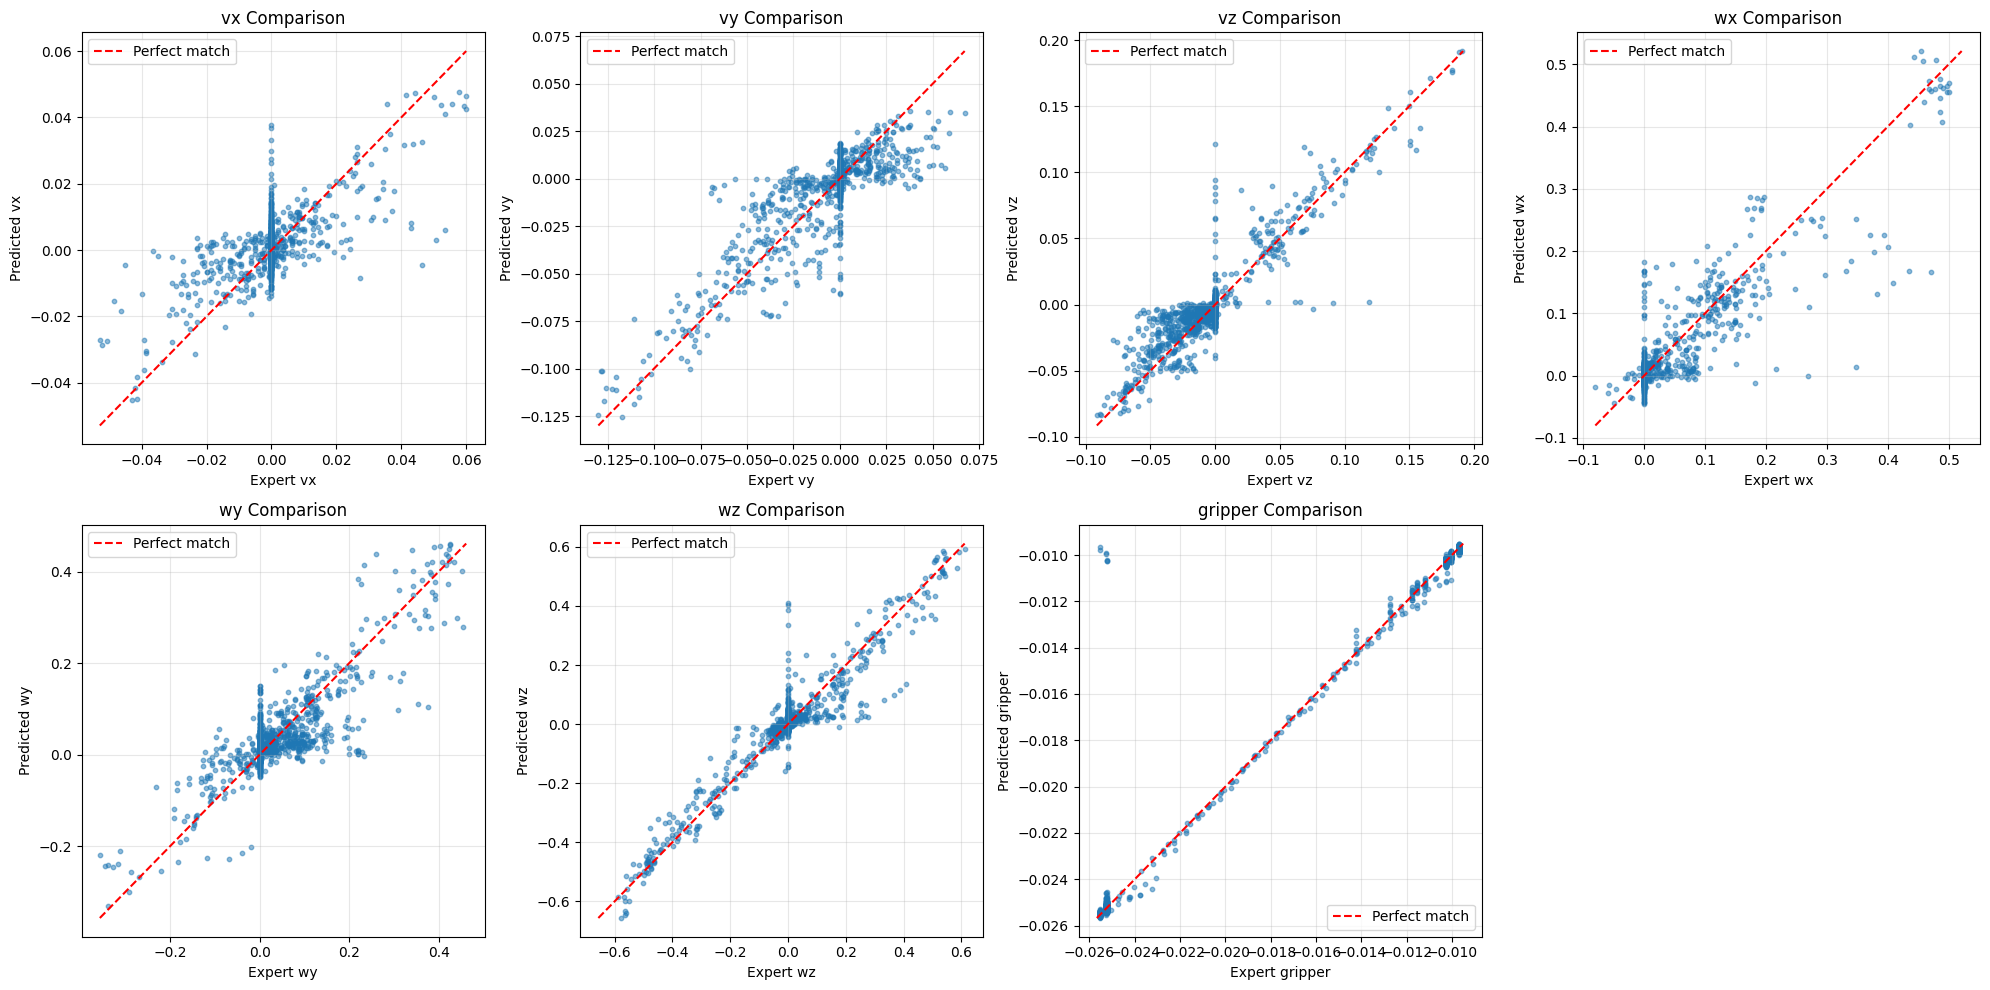

In [10]:
# Plot comparisons
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, name in enumerate(action_names):
    ax = axes[i]
    ax.scatter(expert_actions_denormalized_aligned[:, i], predicted_actions_denormalized[:, i], 
               alpha=0.5, s=10)
    
    # Plot diagonal line (perfect match)
    min_val = min(np.min(expert_actions_denormalized_aligned[:, i]), np.min(predicted_actions_denormalized[:, i]))
    max_val = max(np.max(expert_actions_denormalized[:, i]), np.max(predicted_actions_denormalized[:, i]))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect match')
    
    ax.set_xlabel(f'Expert {name}')
    ax.set_ylabel(f'Predicted {name}')
    ax.set_title(f'{name} Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove last subplot if odd number
if len(action_names) < len(axes):
    axes[-1].remove()

plt.tight_layout()
plt.savefig('action_comparison.png', dpi=150)
print("Saved plot to action_comparison.png")
plt.show()

Saved plot to error_distributions.png


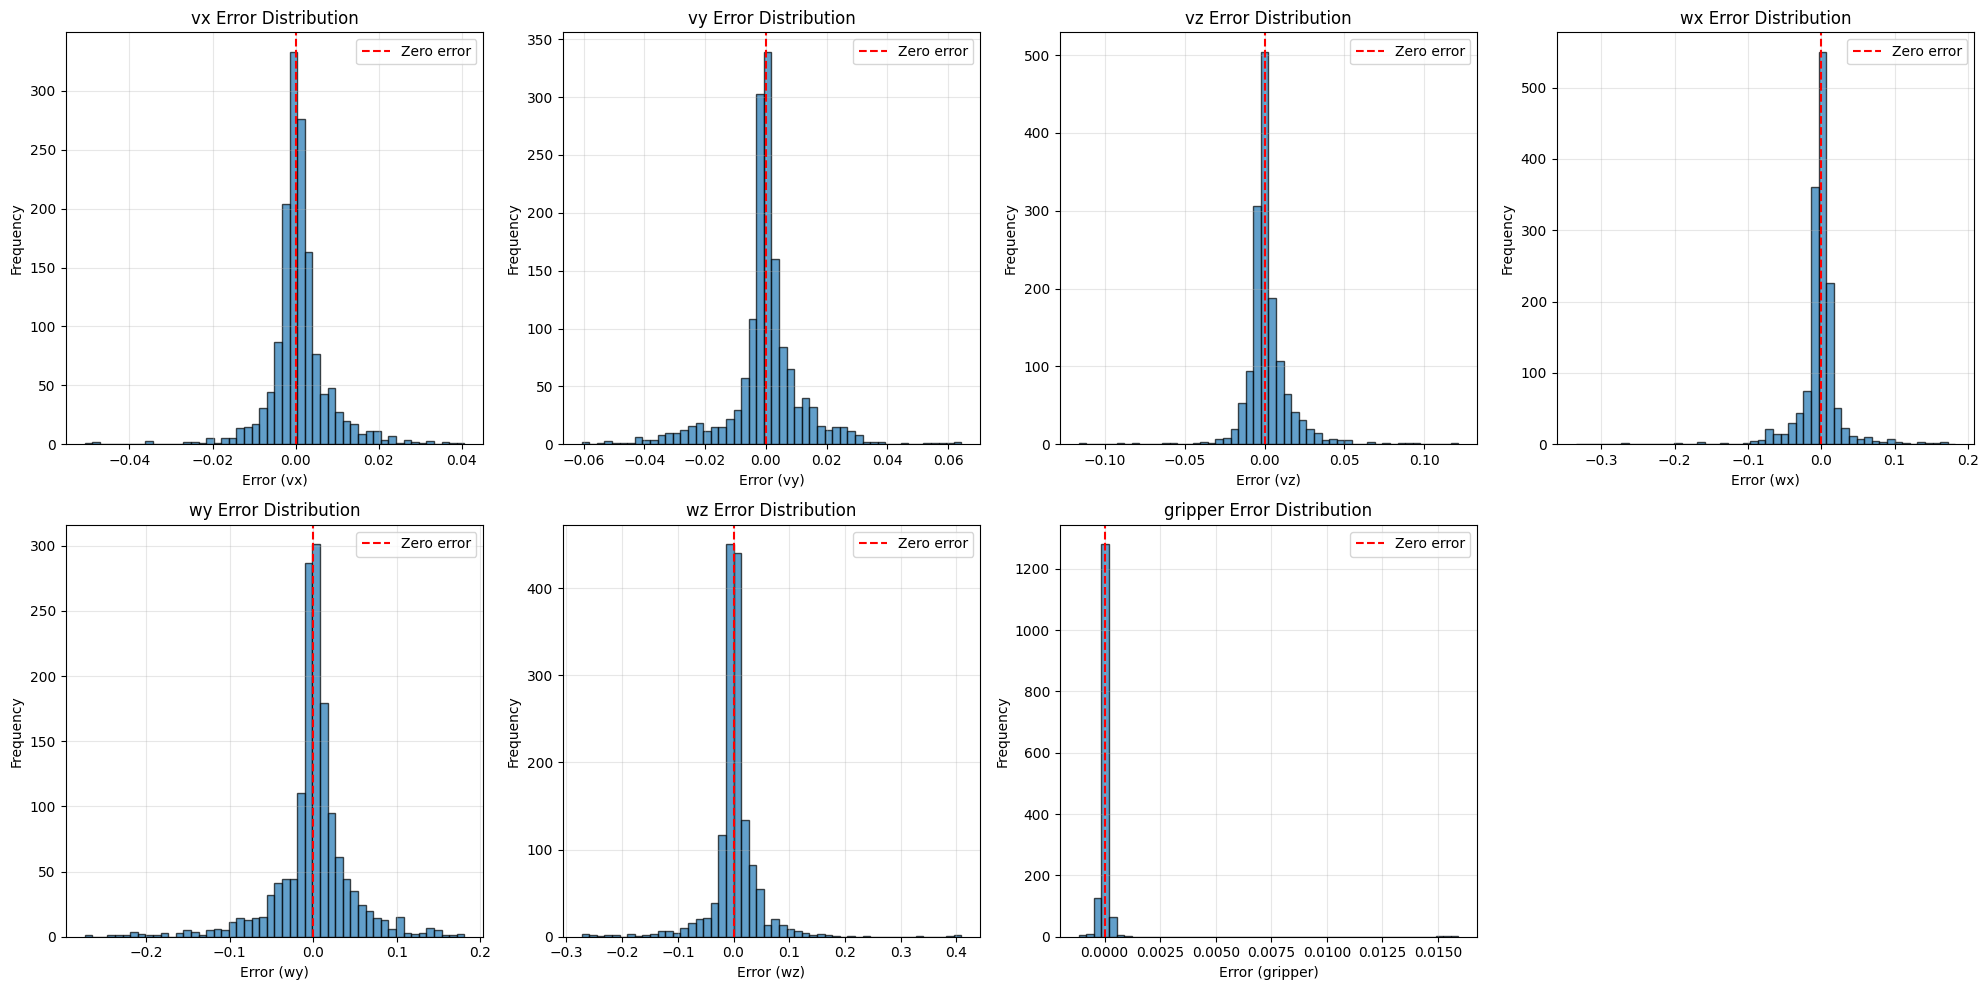

In [11]:
# Plot error distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, name in enumerate(action_names):
    ax = axes[i]
    ax.hist(differences[:, i], bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='r', linestyle='--', label='Zero error')
    ax.set_xlabel(f'Error ({name})')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name} Error Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove last subplot if odd number
if len(action_names) < len(axes):
    axes[-1].remove()

plt.tight_layout()
plt.savefig('error_distributions.png', dpi=150)
print("Saved plot to error_distributions.png")
plt.show()

Saved plot to time_series_comparison_chunked.png
Showing 250 policy queries over 1000 timesteps
Expert actions: continuous at every timestep (not chunked)
Predicted actions: chunked execution (policy queried at steps: [0, 4, 8, 12, 16, 20, 24, 28, 32, 36]...)


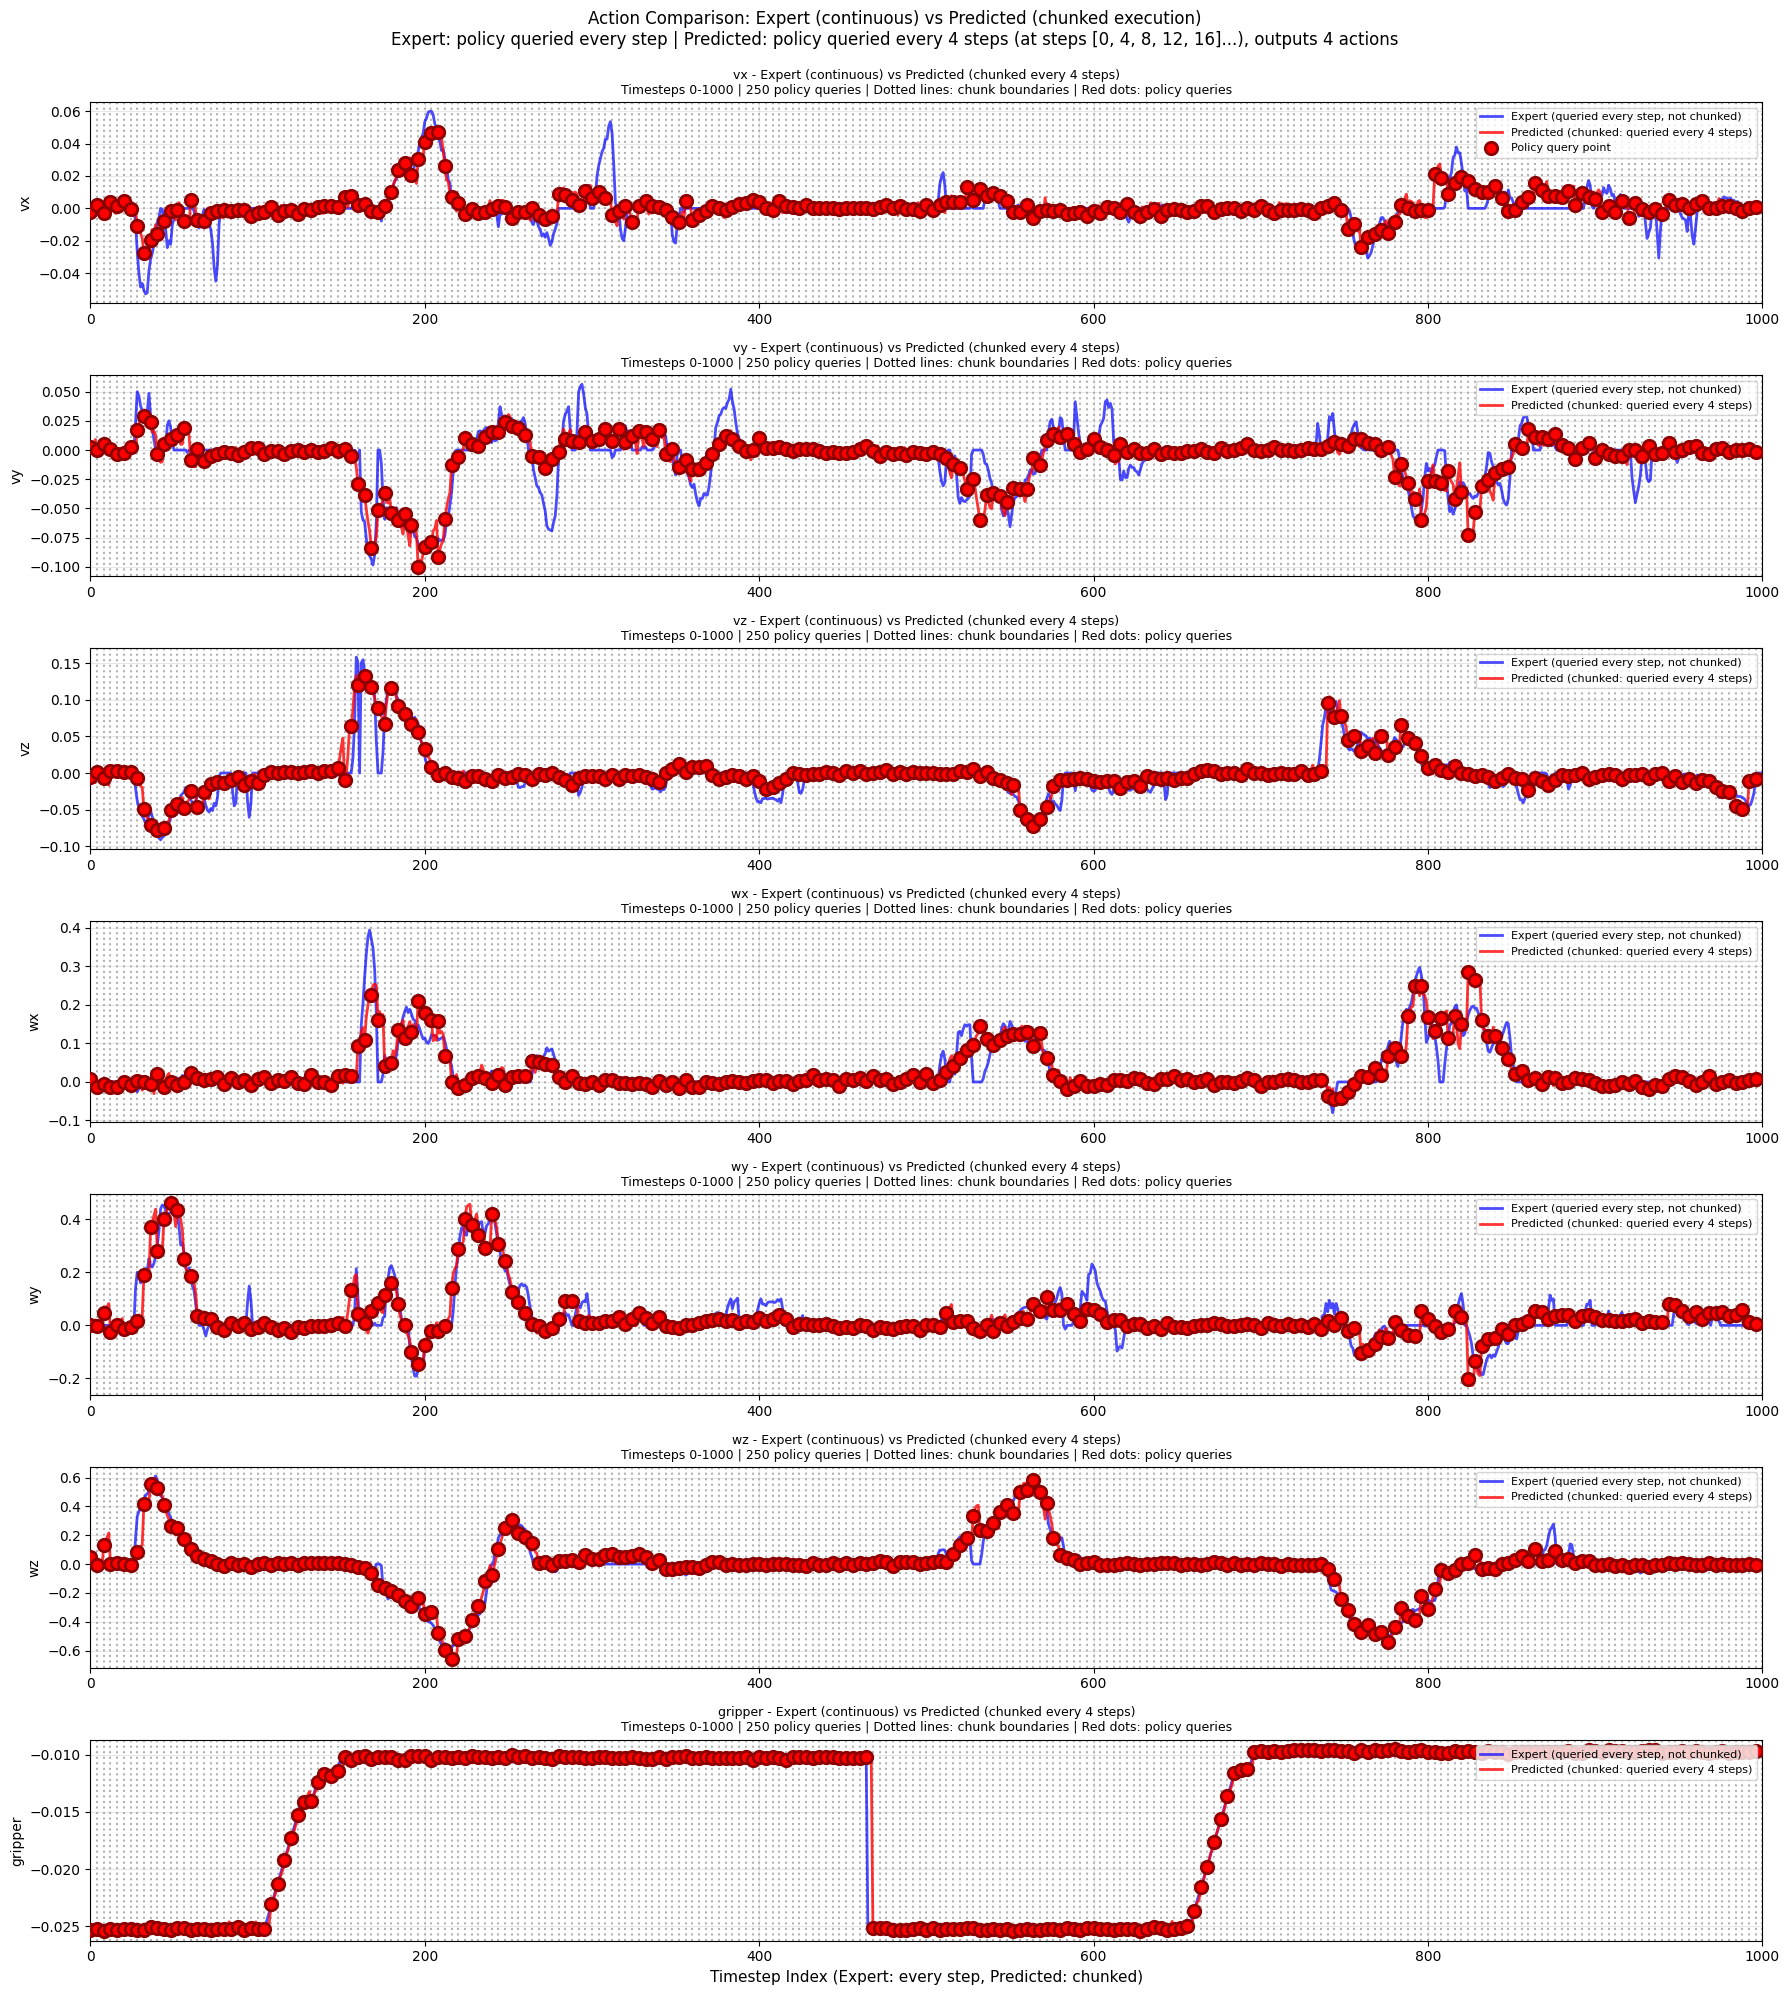

In [12]:
# Plot time series comparison showing chunked execution
# Expert actions: queried every step (continuous, not chunked)
# Predicted actions: queried every horizon_length steps (0, 4, 8, 12...), outputs chunk of actions
fig, axes = plt.subplots(7, 1, figsize=(18, 20))

sample_start = 0
max_samples_to_plot = min(1000, NUM_SAMPLES)  # Use raw expert actions length
sample_end = max_samples_to_plot

# Get policy query steps that fall within our plot range
plot_policy_query_steps = [step for step in policy_query_steps if step < sample_end]
num_chunks_to_plot = len(plot_policy_query_steps)

for i, name in enumerate(action_names):
    ax = axes[i]
    
    # Plot expert actions in normal time (every timestep, not chunked)
    # Expert actions are at timesteps 0, 1, 2, 3, 4, 5, ... (continuous)
    x_expert = np.arange(sample_start, sample_end)
    ax.plot(x_expert, expert_actions_denormalized[sample_start:sample_end, i], 
            'b-', label='Expert (queried every step, not chunked)', linewidth=2, alpha=0.7)
    
    # Plot predicted actions showing chunked execution
    # Policy is queried at steps in plot_policy_query_steps (0, 4, 8, 12...)
    # Each query outputs a chunk that applies to [query_step, query_step+1, query_step+2, query_step+3]
    predicted_timesteps = []
    predicted_values = []
    
    for chunk_idx, query_step in enumerate(plot_policy_query_steps):
        # For each action in this chunk, plot it at the corresponding timestep
        for step_in_chunk in range(horizon_length):
            timestep = query_step + step_in_chunk
            if timestep >= sample_end:
                break
            
            # Get action value from chunk
            action_value = predicted_action_chunks_denormalized[chunk_idx, step_in_chunk, i]
            predicted_timesteps.append(timestep)
            predicted_values.append(action_value)
    
    # Plot predicted actions (showing they come from chunks)
    if len(predicted_timesteps) > 0:
        ax.plot(predicted_timesteps, predicted_values, 
                'r-', linewidth=2, alpha=0.8, label=f'Predicted (chunked: queried every {horizon_length} steps)', 
                drawstyle='default')  # Regular line, not steps-post, since each action is different
    
    # Add vertical lines to show chunk boundaries (policy query points)
    chunk_boundaries = plot_policy_query_steps + [sample_end]  # Add end boundary
    for boundary in chunk_boundaries:
        if boundary <= sample_end:
            ax.axvline(x=boundary, color='gray', linestyle=':', alpha=0.6, linewidth=1.5, zorder=1)
    
    # Add markers at policy query points (start of each chunk) - show when policy is actually called
    if len(plot_policy_query_steps) > 0:
        # Get the first action value of each chunk at query points
        query_values = [predicted_action_chunks_denormalized[chunk_idx, 0, i] 
                       for chunk_idx in range(len(plot_policy_query_steps))]
        ax.scatter(plot_policy_query_steps, query_values, color='red', s=80, marker='o', 
                  zorder=5, label='Policy query point' if i == 0 else '', 
                  edgecolors='darkred', linewidths=2)
    
    ax.set_ylabel(name, fontsize=10)
    title = f'{name} - Expert (continuous) vs Predicted (chunked every {horizon_length} steps)\n' + \
            f'Timesteps {sample_start}-{sample_end} | {num_chunks_to_plot} policy queries | ' + \
            f'Dotted lines: chunk boundaries | Red dots: policy queries'
    ax.set_title(title, fontsize=9)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(sample_start, sample_end)

axes[-1].set_xlabel('Timestep Index (Expert: every step, Predicted: chunked)', fontsize=11)
plt.suptitle(f'Action Comparison: Expert (continuous) vs Predicted (chunked execution)\n' +
             f'Expert: policy queried every step | Predicted: policy queried every {horizon_length} steps (at steps {plot_policy_query_steps[:min(5, len(plot_policy_query_steps))]}...), outputs {horizon_length} actions', 
             fontsize=12, y=0.995)
plt.tight_layout()
plt.savefig('time_series_comparison_chunked.png', dpi=150, bbox_inches='tight')
print(f"Saved plot to time_series_comparison_chunked.png")
print(f"Showing {num_chunks_to_plot} policy queries over {sample_end} timesteps")
print(f"Expert actions: continuous at every timestep (not chunked)")
print(f"Predicted actions: chunked execution (policy queried at steps: {plot_policy_query_steps[:min(10, len(plot_policy_query_steps))]}...)")
plt.show()

In [13]:
# Summary statistics
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Total action chunks compared: {num_chunks}")
print(f"Total individual actions compared: {len(predicted_actions_denormalized)} ({num_chunks} policy queries × {horizon_length} actions per chunk)")
print(f"\nMean Absolute Error by dimension:")
for i, name in enumerate(action_names):
    mae = np.mean(absolute_differences[:, i])
    print(f"  {name}: {mae:.6f}")

print(f"\nOverall statistics:")
print(f"  Mean Absolute Error: {np.mean(absolute_differences):.6f}")
print(f"  Root Mean Squared Error: {np.sqrt(np.mean(differences**2)):.6f}")
print(f"  Max Absolute Error: {np.max(absolute_differences):.6f}")

# Percentage of predictions within certain thresholds
thresholds = [0.01, 0.05, 0.1, 0.25]
print(f"\nPercentage of predictions within threshold (per dimension):")
for threshold in thresholds:
    print(f"\n  Threshold: {threshold}")
    for i, name in enumerate(action_names):
        within_threshold = np.mean(absolute_differences[:, i] < threshold) * 100
        print(f"    {name}: {within_threshold:.1f}%")


SUMMARY
Total action chunks compared: 375
Total individual actions compared: 1500 (375 policy queries × 4 actions per chunk)

Mean Absolute Error by dimension:
  vx: 0.004415
  vy: 0.007387
  vz: 0.007901
  wx: 0.017046
  wy: 0.027960
  wz: 0.023789
  gripper: 0.000168

Overall statistics:
  Mean Absolute Error: 0.012666
  Root Mean Squared Error: 0.028976
  Max Absolute Error: 0.408939

Percentage of predictions within threshold (per dimension):

  Threshold: 0.01
    vx: 88.3%
    vy: 76.7%
    vz: 75.8%
    wx: 60.7%
    wy: 42.1%
    wz: 50.4%
    gripper: 99.5%

  Threshold: 0.05
    vx: 99.9%
    vy: 99.1%
    vz: 98.7%
    wx: 92.0%
    wy: 82.6%
    wz: 87.9%
    gripper: 100.0%

  Threshold: 0.1
    vx: 100.0%
    vy: 100.0%
    vz: 99.9%
    wx: 97.6%
    wy: 94.7%
    wz: 95.8%
    gripper: 100.0%

  Threshold: 0.25
    vx: 100.0%
    vy: 100.0%
    vz: 100.0%
    wx: 99.6%
    wy: 99.9%
    wz: 99.4%
    gripper: 100.0%


In [14]:
print('done')

done
